We first load in the titanic dataset using pandas, and fill in NaN values with the median of the corresponding data.

In [2]:
import sklearn
import pandas as pd
import numpy as np
titanicData = pd.read_csv("titanic4real.csv")

def cleanupTitanic(titanicData, changePclass=False):
    """Returns: X -- features, y--labels"""
    categorical_features = ['Sex']
    num_features = ['Fare', 'Age']
    if changePclass:
        categorical_features.append('Pclass')
    else:
        num_features.append('Pclass')
    
    labelName = 'Survived'
    for feature in num_features:
        titanicData[feature] = titanicData[feature].fillna(titanicData[feature].median())
    y = titanicData[labelName].as_matrix()
    
    X = titanicData[num_features].as_matrix()
    for feature in categorical_features:
        X = np.hstack([X, pd.get_dummies(titanicData[feature]).as_matrix()])
    #all who did not survive died
    y[y!=1] = 0
    return X, y

features, labels = cleanupTitanic(titanicData)
changed_features = cleanupTitanic(titanicData, changePclass=True)[0]

Having created two sets of features -- those with pclass as a single feature and broken down into into multiple features, we seek to determine which feature representation allows for better learning. In the below code we divide the dataset into training and testing sets, using a 60-40 split.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

npoints = features.shape[0]
ntrain = int(.6*npoints)
inds = np.arange(npoints)
np.random.shuffle(inds)
train_mask = inds[:ntrain]
test_mask = inds[ntrain:]

We now traing 4 different models, selecting optimal parameters for each, and then compare results. (Spoiler Alert: Logistic Regression wins.)

Logistic Regression


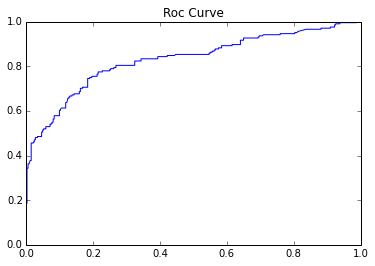

AUC Score: 0.830208 
Changed Logistic Regression


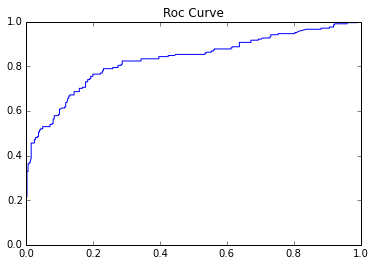

AUC Score: 0.830162 
Naive Bayes


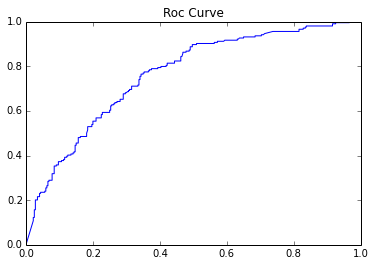

AUC Score: 0.761198 
Modified Naive Bayes


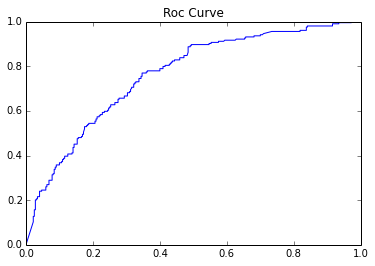

AUC Score: 0.761527 


In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
%matplotlib inline

def show_results(model, train, test, train_labels, test_labels):
    model.fit(train, train_labels)
    probs = model.predict_proba(test)[:,1]
    fpr, tpr, taus = roc_curve(test_labels, probs, pos_label=1)
    plt.plot(fpr, tpr)
    plt.title("Roc Curve")
    plt.show()
    print "AUC Score: %f " % auc(fpr, tpr)

def best_C(train, test, train_labels, test_labels, nchoices=10):
    bestC=None
    bestScore=-np.inf
    for c in np.linspace(0.1,1,nchoices):
        model = LogisticRegression(C=c)
        model.fit(train, train_labels)
        probs = model.predict_proba(test)[:,1]
        score = roc_auc_score(test_labels, probs)
        if score > bestScore:
            bestScore = score
            bestC = c
    return bestC

def best_alpha(train, test, train_labels, test_labels, nchoices=10):
    bestAlpha=None
    bestScore=-np.inf
    for alpha in np.linspace(0.1,1,nchoices):
        model = MultinomialNB(alpha=alpha)
        model.fit(train, train_labels)
        probs = model.predict_proba(test)[:,1]
        score = roc_auc_score(test_labels, probs)
        if score > bestScore:
            bestScore = score
            bestAlpha = alpha
    return bestAlpha


#determine best params
C1 = best_C(features[train_mask], features[test_mask], labels[train_mask], labels[test_mask])
C2 = best_C(changed_features[train_mask], changed_features[test_mask], labels[train_mask], labels[test_mask])
alpha1 = best_alpha(features[train_mask], features[test_mask], labels[train_mask], labels[test_mask])
alpha2 = best_alpha(changed_features[train_mask], changed_features[test_mask], labels[train_mask], labels[test_mask])

logreg = LogisticRegression(C=C1)
logreg_changed = LogisticRegression(C=C2)
bayes = MultinomialNB(alpha=alpha1)
bayes_changed = MultinomialNB(alpha=alpha2)
print "Logistic Regression"
show_results(logreg, features[train_mask], features[test_mask], labels[train_mask], labels[test_mask])
print "Changed Logistic Regression"
show_results(logreg_changed, changed_features[train_mask], changed_features[test_mask], labels[train_mask], labels[test_mask])
print "Naive Bayes"
show_results(bayes, features[train_mask], features[test_mask], labels[train_mask], labels[test_mask])
print "Modified Naive Bayes"
show_results(bayes_changed, changed_features[train_mask], changed_features[test_mask], labels[train_mask], labels[test_mask])


With optimal parameter choices, Bayes benefits slightly from the dummy coding, while Logistic Regression is unaffected.